In [5]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import zipfile
import os

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold

from helper_functions import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

## Reading the Data

In [6]:
full_data = pd.read_csv('cook_county_train.csv')

## Split into Training & Validation

In [7]:
train, valid = train_val_split(full_data)

In [8]:
X_train, y_train =process_data_pipe(train, process_pipeline, 'Sale Price')
X_test, y_test = process_data_pipe(valid, process_pipeline, 'Sale Price')

In [9]:
X_train.drop(['PIN', 'Construction Quality', 'Site Desirability', 'Other Improvements', 'Deed No.',
                   'Sale Half of Year', 'Sale Quarter of Year', 'Description', 'Modeling Group', 'Unnamed: 0', 
                'Estimate (Land)', 'Estimate (Building)'
               ], axis=1, inplace=True)

X_test.drop(['PIN', 'Construction Quality', 'Site Desirability', 'Other Improvements', 'Deed No.',
                   'Sale Half of Year', 'Sale Quarter of Year', 'Description', 'Modeling Group', 'Unnamed: 0', 
                'Estimate (Land)', 'Estimate (Building)'
               ], axis=1, inplace=True)
X_train = X_train.values
y_train = y_train.values

In [10]:
X_test = X_test.values
y_test = y_test.values

In [11]:
def rmse_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [12]:
def build_model(num_layers, input_dim):
    model = Sequential()
    model.add(Input(shape=(input_dim,)), Dense(64, activation = 'relu'))

    for _ in range(num_layers - 1):
        model.add(Dense(64, activation = 'relu'))

    model.add(Dense(1, activation = 'linear'))
    model.compile(
        optimizer = Adam(learning_rate = 0.001),
        loss = rmse_loss,
        metrics = [tf.keras.metrics.RootMeanSquaredError()]
    )
    return model

## Determining Optimal Number of Layers

In [13]:
layer_options = [5, 7, 10]
results = []

kf = KFold(n_splits=3, shuffle=True, random_state=39)

early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error', 
    patience=5,      
    restore_best_weights=True,
)
for num_layers in layer_options:
    fold_rmse = []
    fold = 1
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        model = build_model(num_layers, input_dim = X_train.shape[1])
        history = model.fit(
            X_train_fold, y_train_fold,
            epochs = 15,
            batch_size = 32,
            validation_split = 0.1,
            callbacks=[early_stopping],
            verbose = 0
        )
        final_val_loss = history.history['val_loss'][-1]
        final_val_rmse  = history.history['val_root_mean_squared_error'][-1]
        print(f"Layers: {num_layers}, Fold {fold} RMSE: {final_val_rmse:.2f}")
        fold_rmse.append(final_val_rmse)
        fold += 1
    avg_rmse = np.mean(fold_rmse)
    results.append((num_layers, avg_rmse))
    print(f"Average RMSE for {num_layers} layesr: {avg_rmse:.2f}\n")

    results.append((num_layers, final_val_rmse))
for (layers, rmse) in results:
    print(f"Layers: {layers} | Final Val RMSE: {rmse:.4f}")

best_config = min(results, key=lambda x: x[1])
print(f"\nBest configuration based on validation loss: {best_config[0]} layers")

Layers: 5, Fold 1 RMSE: 226873.52
Layers: 5, Fold 2 RMSE: 230180.83
Layers: 5, Fold 3 RMSE: 240797.22
Average RMSE for 5 layesr: 232617.19

Layers: 7, Fold 1 RMSE: 231758.25
Layers: 7, Fold 2 RMSE: 240186.86
Layers: 7, Fold 3 RMSE: 235378.38
Average RMSE for 7 layesr: 235774.49

Layers: 10, Fold 1 RMSE: 229501.53
Layers: 10, Fold 2 RMSE: 237890.19
Layers: 10, Fold 3 RMSE: 242571.28
Average RMSE for 10 layesr: 236654.33

Layers: 5 | Final Val RMSE: 232617.1875
Layers: 5 | Final Val RMSE: 240797.2188
Layers: 7 | Final Val RMSE: 235774.4948
Layers: 7 | Final Val RMSE: 235378.3750
Layers: 10 | Final Val RMSE: 236654.3333
Layers: 10 | Final Val RMSE: 242571.2812

Best configuration based on validation loss: 5 layers


In [25]:
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'linear')
])

early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error', 
    patience=5,      
    restore_best_weights=True,
)
model.compile(optimizer = Adam(learning_rate = 0.001), loss = rmse_loss, metrics = [tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(X_train, y_train, epochs=75, batch_size=32, callbacks=[early_stopping], validation_split=0.2)

# 7. Evaluating the Model
loss, rmse = model.evaluate(X_test, y_test)
print("Test RMSE:", rmse)

Epoch 1/75
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 280402.6875 - root_mean_squared_error: 376809.5000 - val_loss: 227904.9531 - val_root_mean_squared_error: 247012.3281
Epoch 2/75
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 236063.9375 - root_mean_squared_error: 335662.0000 - val_loss: 230186.5000 - val_root_mean_squared_error: 249709.0000
Epoch 3/75
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 228306.3281 - root_mean_squared_error: 277421.8750 - val_loss: 233441.9688 - val_root_mean_squared_error: 252725.8438
Epoch 4/75
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 231003.6406 - root_mean_squared_error: 282569.4688 - val_loss: 234907.4531 - val_root_mean_squared_error: 254028.2812
Epoch 5/75
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 232337.5469 - root_mean_squared_error: 315528.0625 - val_loss: 230022.4219 - val_root_mean_squared_error: 247002.5781
Epoch 6/75
4096/4096 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 228239.4531 - root_mean_squared_

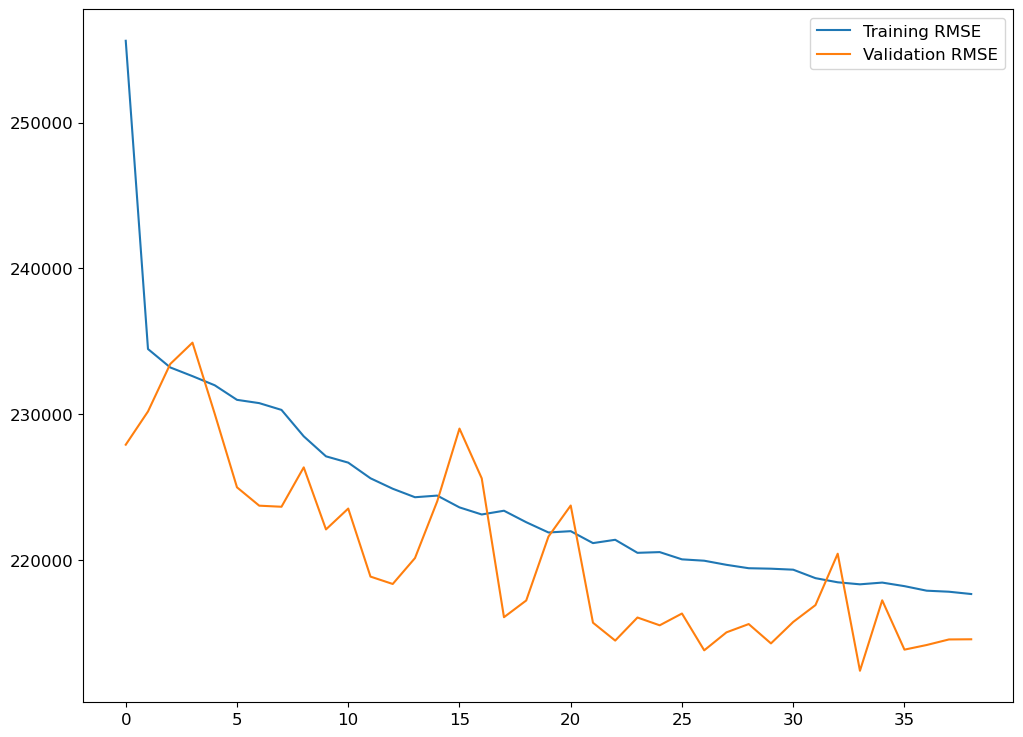

In [28]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training RMSE')
plt.plot(history.history['val_loss'], label='Validation RMSE')
plt.legend()
plt.show()

In [32]:
model.save('best_model.keras')